# GUT of Imaging Results


In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(3000,)
(3000,)
(32940,)


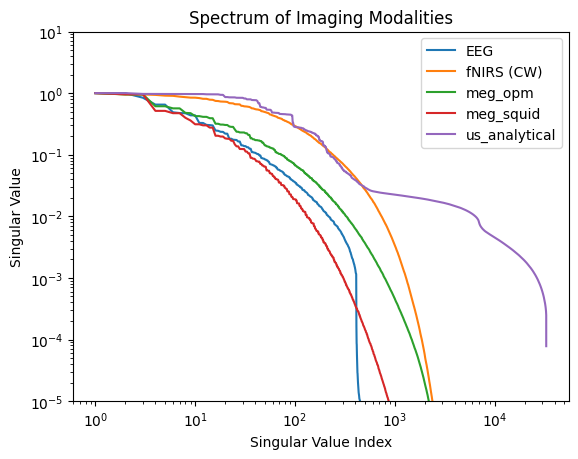

In [14]:
from guti.data_utils import load_all_svds

# Load all SVD spectrums
all_svds = load_all_svds()

# Plot all spectrums
for modality_name, (s, params) in all_svds.items():
    plt.plot(
        np.arange(1, len(s) + 1),
        s / s[0],
        label=modality_name,
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.title("Spectrum of Imaging Modalities")
plt.legend()
plt.ylim(1e-5, 10)
plt.savefig("spectrum.png")
plt.show()

In [ ]:
from guti.core import get_bitrate_channel_capacity

snr_per_modalities = {
    "EEG": 100.0,
    "fNIRS (CW)": 100.0,
    "meg_opm": 100.0,
    "meg_squid": 100.0,
    "us_analytical": 100.0
}

time_resolution_per_modality = {
    "EEG": 10e-3,
    "fNIRS (CW)": 1.0,
    "meg_opm": 10e-3,
    "meg_squid": 10e-3,
    "us_analytical": 1.0,
}

channel_capacities = {}

# Plot all spectrums
for modality_name, (s, params) in all_svds.items():
    channel_capacity = get_bitrate_channel_capacity(s.astype(np.float64),
        snr_at_reference_nsensors=snr_per_modalities[modality_name],
        time_resolution=time_resolution_per_modality[modality_name]
    )
    if modality_name == "us_analytical":
        channel_capacity *= (1000/40)**3
    channel_capacities[modality_name] = channel_capacity

    print(f"{modality_name}: {channel_capacities[modality_name]:.2f} bits/s")




EEG: 333163567.03 bits/s
fNIRS (CW): 8514347.86 bits/s
meg_opm: 478467360.19 bits/s
meg_squid: 266624022.81 bits/s
us_analytical: 7765581.53 bits/s
